# Web scrape Geotab data
A tool to scrape data from the range calculator in Geotab's blog article: https://www.geotab.com/blog/ev-range/

Before running: `conda install beautifulsoup4 requests`

In [1]:
import json
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from bs4 import BeautifulSoup

In [2]:
# the url we are going to scrape
URL = "https://storage.googleapis.com/geotab_wfm_production_cms_storage/CMS-GeneralFiles-production/NA/EV/EVTOOL.html"

In [3]:
# get the content from the url
r = requests.get(URL)
# parse the html content
source = BeautifulSoup(r.content, "html.parser")

In [4]:
# keep scripts only
scripts = source.find_all("script")

In [5]:
# this is a list, and by simply looking at the raw string, we know we want the 1st (car info)
# and the 3rd (scale factors) element
scripts[2]

<script>
    const TEMP_DATA = [
        {
            "Temp": "-23",
            "Range factor relative 21C - overall - Not Tesla": "0.423087273",
            "Range factor relative 21C - 90th - Not Tesla": "0.542401766",
            "Range factor relative 21C - 10th - Not Tesla": "0.293100333",
            "Range factor relative 21C - overall - Tesla": "#N/A",
            "Range factor relative 21C - 90th - Tesla": "#N/A",
            "Range factor relative 21C - 10th - Tesla": "#N/A"
        },
        {
            "Temp": "-22.9",
            "Range factor relative 21C - overall - Not Tesla": "0.423874362",
            "Range factor relative 21C - 90th - Not Tesla": "0.543469767",
            "Range factor relative 21C - 10th - Not Tesla": "0.293688864",
            "Range factor relative 21C - overall - Tesla": "#N/A",
            "Range factor relative 21C - 90th - Tesla": "#N/A",
            "Range factor relative 21C - 10th - Tesla": "#N/A"
        },
        {
            "Te

In [6]:
# get and clean up the car data (strip unnecessary string)
ev_data = scripts[0].string.lstrip("\r\n    const EV_DATA = ")
# load as a json object
json_obj = json.loads(ev_data)

In [7]:
# it contains data for these EVs
json_obj.keys()

dict_keys(['Bmw i3 ', 'Chevrolet Bolt ', 'Chevrolet Spark ', 'Coda Sedan ', 'Fiat 500e ', 'Ford Focus ', 'Honda Fit ', 'Hyundai Ioniq Electric ', 'Hyundai Kona ', 'Kia Soul ', 'Mercedes-Benz B-Class ', 'Mitsubishi iMiEV ', 'Nissan eNV200 ', 'Nissan Leaf ', 'Renault Zoe ', 'Renault Kangoo Z.E. ', 'Smart For Two Electric Drive ', 'Tesla Model S', 'Tesla Model 3 ', 'Think City ', 'Toyota RAV4', 'Volkswagen e-Golf '])

In [8]:
# take a look at the data
json_obj['Tesla Model 3 ']

{'2018': {'54': {'MMY': 'Tesla Model 3 2018',
   'Make': 'Tesla',
   'Model': 'Model 3 ',
   'Trim details': '',
   'Year': '2018',
   'Median peak fuel efficieny (21C) wh/km': '157.6561135',
   'Battery size (kwh) - at purchase': '54',
   '21C range (km)-original': '342.5176404',
   'Powertrain': 'EV'}},
 '2019': {'54': {'MMY': 'Tesla Model 3 2019',
   'Make': 'Tesla',
   'Model': 'Model 3 ',
   'Trim details': '',
   'Year': '2019',
   'Median peak fuel efficieny (21C) wh/km': '152.44',
   'Battery size (kwh) - at purchase': '54',
   '21C range (km)-original': '354',
   'Powertrain': 'EV'}}}

In [9]:
# do the same thing for scale factors
factor_data = scripts[2].string
factor_data = factor_data.lstrip("\r\n    const TEMP_DATA = ")
factors = json.loads(factor_data)

In [10]:
# take a look at what the data look like so that we can write codes to extract useful data
factors[0]

{'Temp': '-23',
 'Range factor relative 21C - overall - Not Tesla': '0.423087273',
 'Range factor relative 21C - 90th - Not Tesla': '0.542401766',
 'Range factor relative 21C - 10th - Not Tesla': '0.293100333',
 'Range factor relative 21C - overall - Tesla': '#N/A',
 'Range factor relative 21C - 90th - Tesla': '#N/A',
 'Range factor relative 21C - 10th - Tesla': '#N/A'}

In [11]:
temps = np.zeros(len(factors))
tesla_factor_10th = np.zeros(len(factors))
tesla_factor_original = np.zeros(len(factors))
tesla_factor_90th = np.zeros(len(factors))
not_tesla_factor_10th = np.zeros(len(factors))
not_tesla_factor_original = np.zeros(len(factors))
not_tesla_factor_90th = np.zeros(len(factors))

In [12]:
for i, f in zip(range(len(factors)), factors):
    # temperature
    temps[i] = f["Temp"]
    # factor for non-Tesla EVs
    not_tesla_factor_10th[i] = f["Range factor relative 21C - 10th - Not Tesla"]
    not_tesla_factor_original[i] = f["Range factor relative 21C - overall - Not Tesla"]
    not_tesla_factor_90th[i] = f["Range factor relative 21C - 90th - Not Tesla"]
    # factor for Tesla EVs
    if f["Range factor relative 21C - overall - Tesla"] == '#N/A':
        tesla_factor_10th[i] = np.nan
        tesla_factor_original[i] = np.nan
        tesla_factor_90th[i] = np.nan
    else:
        tesla_factor_10th[i] = f["Range factor relative 21C - 10th - Tesla"]
        tesla_factor_original[i] = f["Range factor relative 21C - overall - Tesla"]
        tesla_factor_90th[i] = f["Range factor relative 21C - 90th - Tesla"]

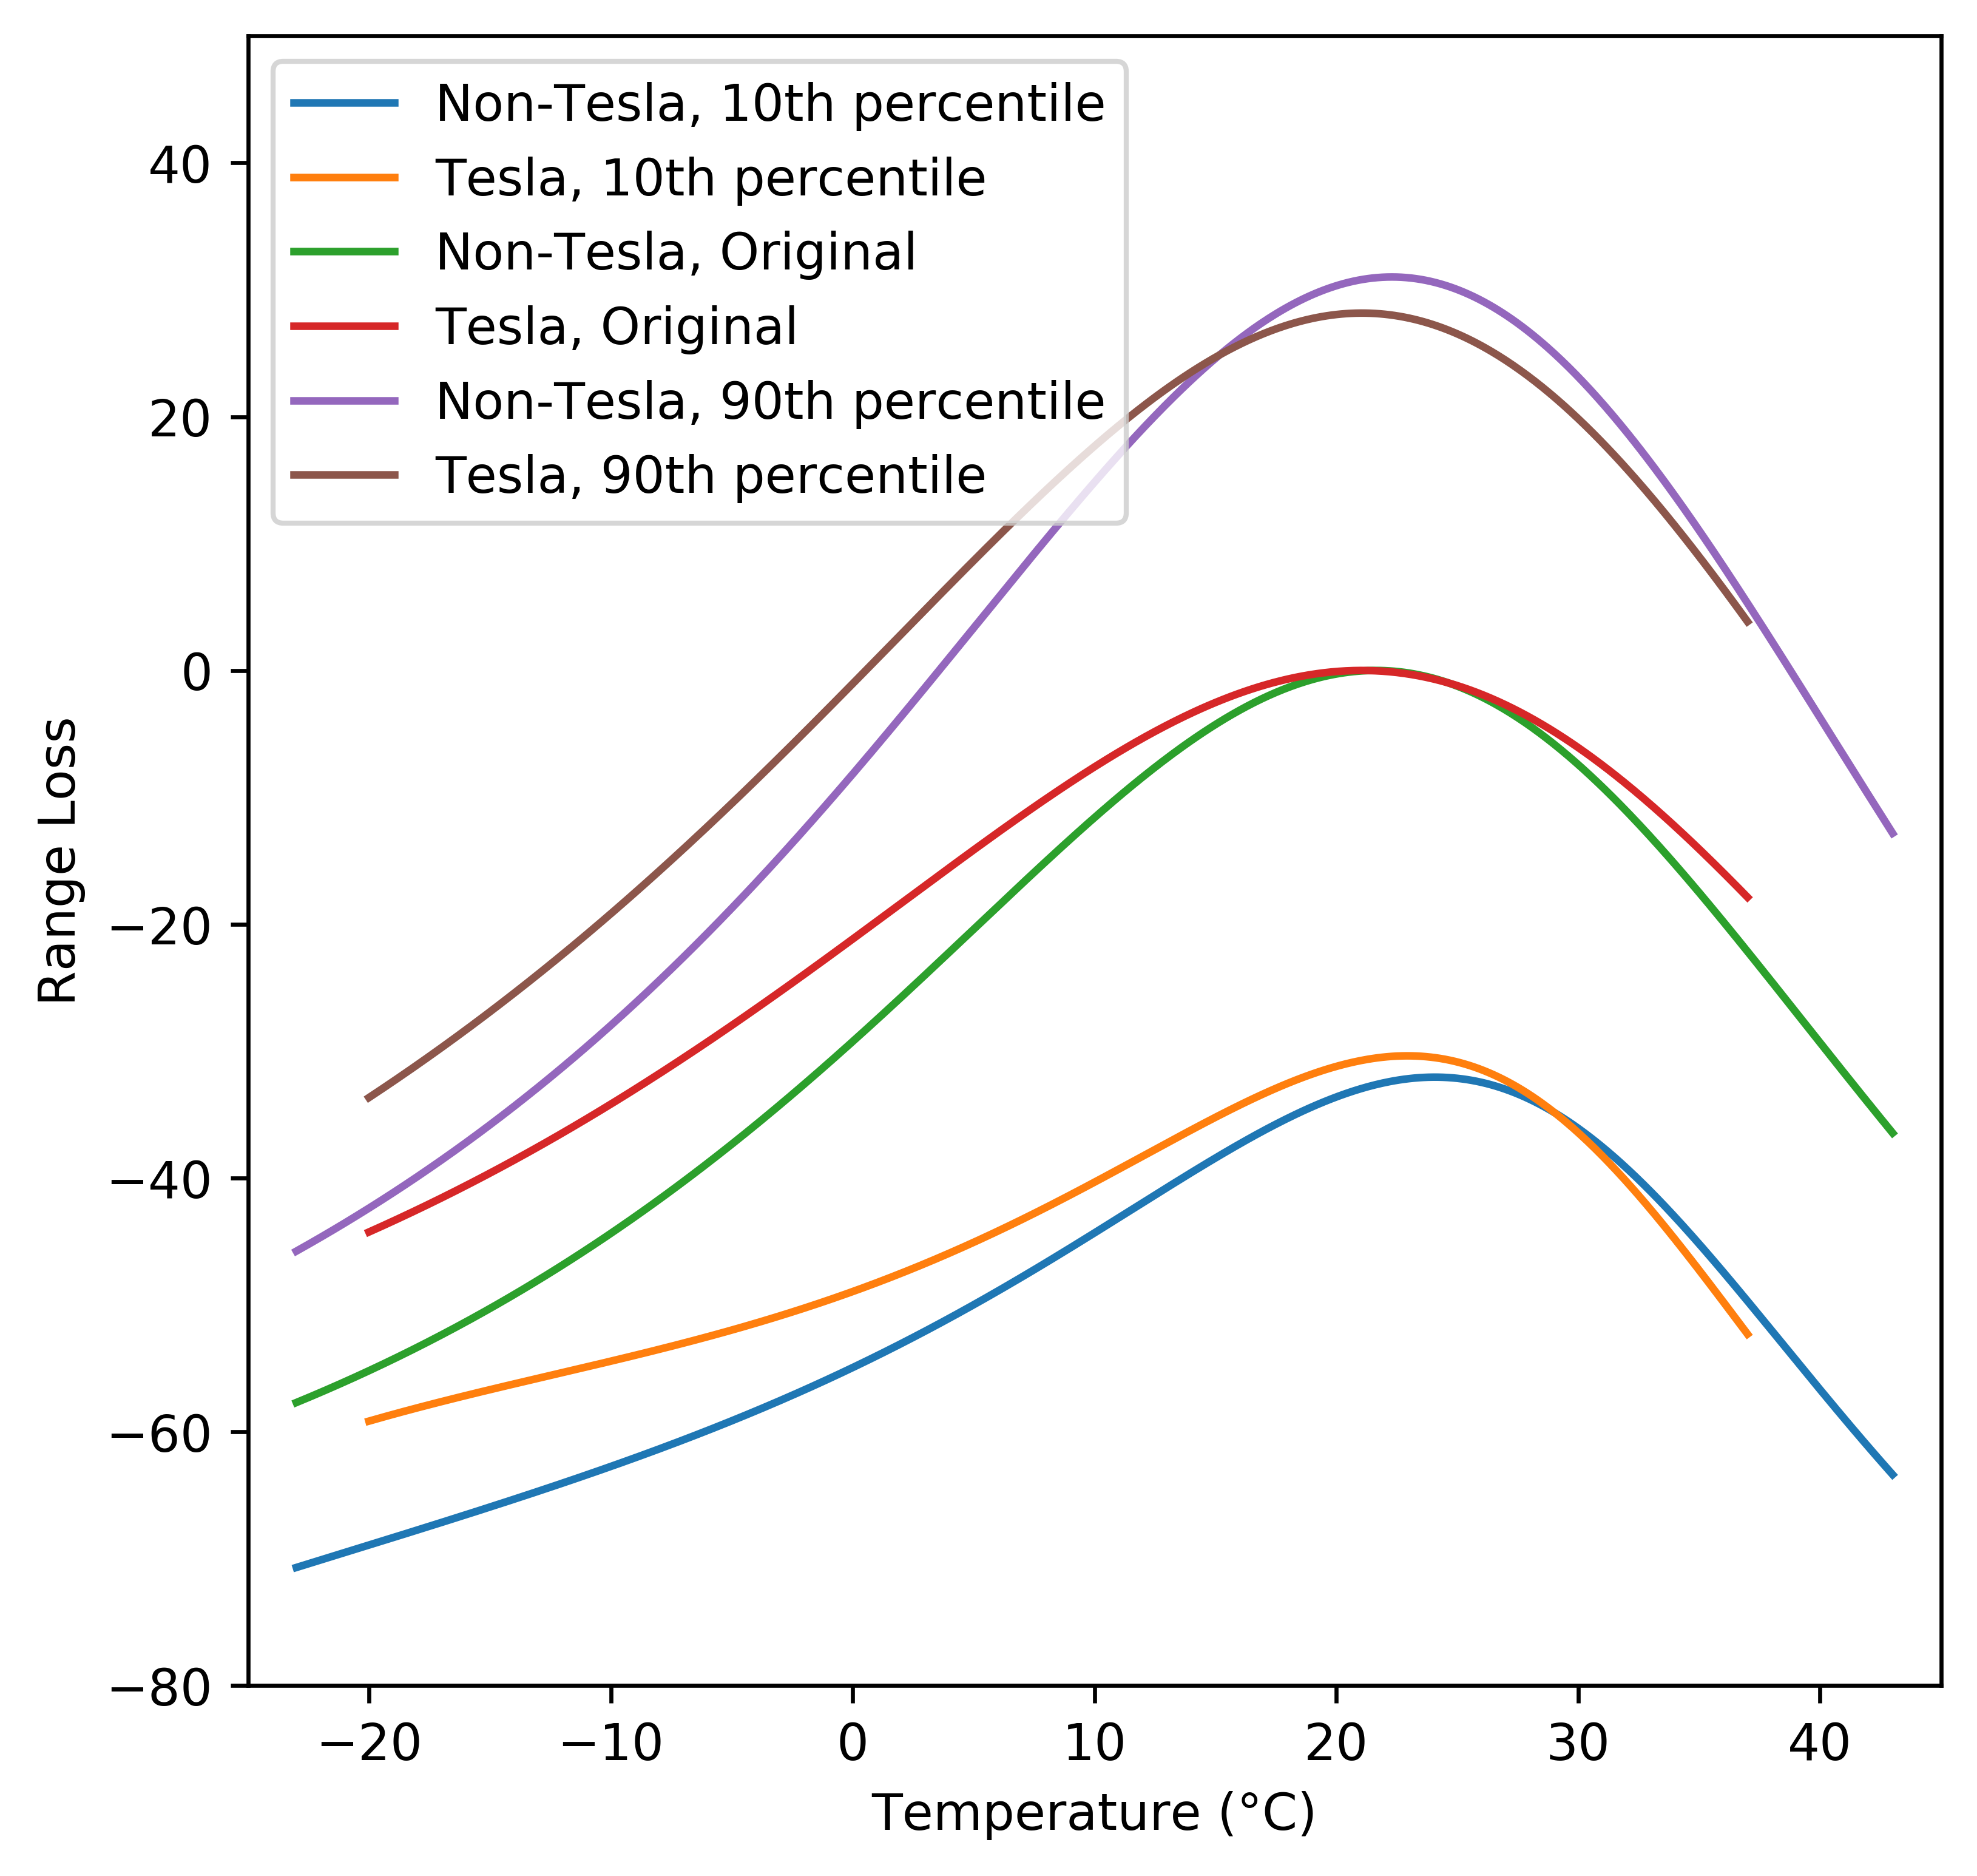

In [13]:
# plot the scale factors vs temperature plot
# NOTE: scale factor*100-100 is equivalent to range loss
plt.figure(figsize=(6, 6), dpi=600)
plt.plot(temps, not_tesla_factor_10th*100-100, label="Non-Tesla, 10th percentile")
plt.plot(temps, tesla_factor_10th*100-100, label="Tesla, 10th percentile")
plt.plot(temps, not_tesla_factor_original*100-100, label="Non-Tesla, Original")
plt.plot(temps, tesla_factor_original*100-100, label="Tesla, Original")
plt.plot(temps, not_tesla_factor_90th*100-100, label="Non-Tesla, 90th percentile")
plt.plot(temps, tesla_factor_90th*100-100, label="Tesla, 90th percentile")
plt.xlim((-25, 45))
plt.ylim((-80, 50))
plt.xlabel("Temperature (°C)")
plt.ylabel("Range Loss")

plt.legend()

In [14]:
# save scale factors to a csv file
df = pd.DataFrame([temps, not_tesla_factor_10th, not_tesla_factor_original, not_tesla_factor_90th,
                   tesla_factor_10th, tesla_factor_original, tesla_factor_90th]).transpose()
df.columns = ["Temperature", "Not Tesla Factors - 10th", "Not Tesla Factors - overall", "Not Tesla Factors - 90th",
              "Tesla Factors - 10th", "Tesla Factors - overall", "Tesla Factors - 90th"]
df.to_csv("./data/raw_scale_factors.csv",index=False)

FileNotFoundError: [Errno 2] No such file or directory: './data/raw_scale_factors.csv'